In [ ]:
"""Project: Wine Recommendation Engine
Author: Kamil Jankowski
Contact: https://www.linkedin.com/in/kamil-jankowski-bb8b38165
Created on: April 2020

Description:
Recommendation system helps buyers to find relevant wine bottles to save their time and money.
Python algorithms build co-occurrence matrix and based on description, country, province of origin, variety, reviews (0-100 points) and price segment of wine return from database the most similar products."""

In [39]:
# Loading basic packages

import pandas as pd
import numpy as np
import matplotlib as plt
pd.set_option("display.max.columns", None)

In [3]:
# Insert the path to folder with winemag-data-130k-v2.csv on your desktop
metadata = pd.read_csv('C:/Users/winemag-data-130k-v2.csv', low_memory=False)
metadata.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
# We have "nan" string values, let's remove them and copy columns which will be needed to build engines

wine = metadata[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery']]
wine = wine.query("title != 'NaN' and country != 'NaN' and description != 'NaN' and points != 'NaN' and price != 'NaN' and province != 'NaN' and variety != 'NaN' and winery != 'NaN'")
wine = wine.dropna()

In [6]:
# sort values by points
wine = wine.sort_values('points', ascending=False)
wine.head()

,title,country,description,points,price,province,variety,winery
111756,Château Léoville Las Cases 2010 Saint-Julien,France,"A hugely powerful wine, full of dark, brooding...",100,359.0,Bordeaux,Bordeaux-style Red Blend,Château Léoville Las Cases
42197,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portugal,This is the latest release of what has long be...,100,450.0,Douro,Portuguese Red,Casa Ferreirinha
89729,Salon 2006 Le Mesnil Blanc de Blancs Brut Char...,France,This new release from a great vintage for Char...,100,617.0,Champagne,Chardonnay,Salon
113929,Charles Smith 2006 Royal City Syrah (Columbia ...,US,In 2005 Charles Smith introduced three high-en...,100,80.0,Washington,Syrah,Charles Smith
7335,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Italy,Thick as molasses and dark as caramelized brow...,100,210.0,Tuscany,Prugnolo Gentile,Avignonesi


In [7]:
wine.shape

(120915, 8)

In [9]:
# We have 120 915 observations in 8 columns which is too much to calculate cosine similarity on mine (and most of us) computer so let's use only part of the original database

wine['points'].describe()
quantile = wine["points"].quantile(0.80)
wine = wine.copy().loc[wine["points"] >= quantile]
wine.shape
# Ok, we have 25% of the original database. It should be enough to prepare reliable recommendation engine. If you have more powerful computer, feel free to change used quantile


(11595, 8)

In [10]:
# Let's build the first engine which will be based on description of the wines bottles
wine["description"].head()

111756    A hugely powerful wine, full of dark, brooding...
42197     This is the latest release of what has long be...
89729     This new release from a great vintage for Char...
113929    In 2005 Charles Smith introduced three high-en...
7335      Thick as molasses and dark as caramelized brow...
Name: description, dtype: object

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# To increase accuracy, we remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(wine['description'])

In [13]:
from sklearn.metrics.pairwise import linear_kernel

In [14]:
# Below code will create the cosine similarity matrix which be needed to build engine.
# Be patient, calculation of it would takes a few seconds.
#If you get memory error, increase quantile value used to divide dataframe.

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [15]:
indices = pd.Series(wine.index, index=wine['title']).drop_duplicates()

In [16]:
def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # fit index of the wine to the title
    idx = indices[title]
    
    # similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # show top 10 results with the highest similarity score
    sim_scores = sim_scores[1:11]

    # select indices
    wine_indices = [i[0] for i in sim_scores]

    # return selected wine and the recommendation results in the new dataframe
    rec1 = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery']].iloc[wine_indices]

    frames = [wine[wine["title"] == title], rec1]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    return recommendation

In [17]:
# To get recommendation, you have to use wine title which index is not higher than size of wine dataframe (for quantile = 80 it is 31019)

Recommendation = wine_recommendations('Château Palmer 2009  Margaux')
Recommendation

title country  \
x 1559                         Château Palmer 2009  Margaux  France   
y 6741    La Poderina 2008 Vendemmia Tardiva  (Moscadell...   Italy   
  84585   Horsepower 2011 The Tribe Vineyard Syrah (Wall...      US   
  48203   Barberani 2006 Calcaia  (Orvieto Classico Supe...   Italy   
  120030  Hauner 2010 Carlo Hauner Passito Riserva  (Mal...   Italy   
  126250     Ca' Rugate 2007 La Perlara  (Recioto di Soave)   Italy   
  35969   Barberani 2008 Passito Villa Monticelli Moscat...   Italy   
  25960   Comelli 2011 Eoos Picolit (Colli Orientali del...   Italy   
  15144   Donnafugata 2013 Ben Ryé  (Passito di Pantelle...   Italy   
  11345   Donnafugata 2012 Ben Ryé  (Passito di Pantelle...   Italy   
  112446      Di Majo Norante 2006 Apianae Moscato (Molise)   Italy   

                                                description  points  price  \
x 1559    A beautiful wine, with the firmest tannins sur...      98  380.0   
y 6741    Light in color and bright in intensity, this l...      94   55.0   
  84585   Floral aromas and tight raspberry fruit flavor...      94  110.0   
  48203   Calcaia is an elegant dessert wine from Umbria...      93   42.0   
  120030  Made with Malvasia grapes that have been dried...      94   92.0   
  126250  Inspired by the Italian word for pearl, La Per...      94   63.0   
  35969   Gorgeous and syrupy, this Passito dessert wine...      93   45.0   
  25960   This beautiful, balanced dessert wine opens wi...      93   45.0   
  15144   Made with 100% dried Zibibbo grapes, this eleg...      93   39.0   
  11345   Made with 100% dried Zibibbo grapes, this gene...      93   45.0   
  112446  This is an extraordinary, golden dessert wine ...      94   29.0   

                    province                   variety           winery  
x 1559              Bordeaux  Bordeaux-style Red Blend   Château Palmer  
y 6741               Tuscany                Moscadello      La Poderina  
  84585               Oregon                     Syrah       Horsepower  
  48203        Central Italy               White Blend        Barberani  
  120030   Sicily & Sardinia               White Blend           Hauner  
  126250              Veneto                 Garganega       Ca' Rugate  
  35969        Central Italy                   Moscato        Barberani  
  25960   Northeastern Italy                   Picolit          Comelli  
  15144    Sicily & Sardinia                   Zibibbo      Donnafugata  
  11345    Sicily & Sardinia                   Zibibbo      Donnafugata  
  112446      Southern Italy                   Moscato  Di Majo Norante

In [18]:
# I don't think these are the worthful recommendations. Let's try to fix it and create new column with metadata of wine bottles

In [19]:
# Before it, we have to change price and points on strings
wine['price'] = wine['price'].astype(str) 
wine['points'] = wine['points'].astype(str)

In [20]:
# And remove duplicates in titles
wine['title'].value_counts()

Perrier Jouët 2006 Belle Epoque Brut Rosé  (Champagne)                              3
Lanson NV Extra Age Brut  (Champagne)                                               3
Duckhorn 2014 Merlot (Atlas Peak)                                                   2
Alvear NV Solera 1927 Pedro Ximénez (Montilla-Moriles)                              2
Testarossa 2013 La Rinconada Vineyard Chardonnay (Sta. Rita Hills)                  2
Chacewater 2000 15 Year Old Tawny Dessert Wine Red (Lake County)                    2
Château Haut-Brion 2014  Pessac-Léognan                                             2
Lombard et Cie NV Brut Nature Verzenay Grand Cru  (Champagne)                       2
Domaine Maillard 2013  Corton                                                       2
Fort Ross 2013 Fort Ross Vineyard Stagecoach Road Pinot Noir (Fort Ross-Seaview)    2
Casca Wines 2012 Monte Cascas Vinha das Cardosas Red (Bairrada)                     2
Eichinger 2013 Gaisberg Reserve Riesling (Kamptal)    

In [21]:
wine[wine["title"] == "Charles Heidsieck NV Brut Réserve  (Champagne)"] # We have to be careful because some of the titles are the two or more different wine types with different prices or points

# The best way to do it is add to metadata title of the wine and the rest of the variables 

,title,country,description,points,price,province,variety,winery
23569,Charles Heidsieck NV Brut Réserve (Champagne),France,"A great wine, much more than only a Champagne,...",93,55.0,Champagne,Champagne Blend,Charles Heidsieck


In [22]:
def metadata(x):
    return ''.join(x['country']) + '' + '' .join(x['title']) + ''.join(x['points']) + ' ' + x['price'] + ' ' + ''.join(x['province'] + ' ' + x['variety'])

In [23]:
wine['metadata'] = wine.apply(metadata, axis=1)
wine['metadata'].value_counts()
# As expected, we have couple of duplicates of not only wine title but it price, points, etc. which have to be removed from dataset

USStone The Crows 2010 Three Twins Vineyard Cabernet Sauvignon (Napa Valley)94 85.0 California Cabernet Sauvignon                 2
ItalyCascina delle Rose 2012 Rio Sordo  (Barbaresco)93 60.0 Piedmont Nebbiolo                                                     2
USInspiration 2015 Grenache (Sonoma Valley)93 29.0 California Grenache                                                            2
USFlying Goat Cellars 2011 Salisbury Vineyards Pinot Noir (San Luis Obispo County)93 38.0 California Pinot Noir                   2
FranceDomaine Weinbach 2014 Cuvée Ste. Cathérine Pinot Gris (Alsace)93 53.0 Alsace Pinot Gris                                     2
ItalyRenato Ratti 2013 Conca  (Barolo)93 80.0 Piedmont Nebbiolo                                                                   2
FranceDomaine Zind-Humbrecht 2013 Vieilles Vignes Gewurztraminer (Alsace)93 55.0 Alsace Gewürztraminer                            2
PortugalColinas do Douro 2012 Quinta da Pedra Cavada Grande Reserva Red (Dou

In [24]:
wine = wine.drop_duplicates('metadata')
wine['metadata'].value_counts()
# It's done.

ItalyMazzei 2004 Castello di Fonterutoli Siepi Red (Toscana)94 99.0 Tuscany Red Blend                                      1
USBabcock 2012 Radical Pinot Noir (Sta. Rita Hills)94 60.0 California Pinot Noir                                           1
USSojourn 2009 Vineyard Georges III Cabernet Sauvignon (Rutherford)93 95.0 California Cabernet Sauvignon                   1
ItalyMocali 2010 Riserva  (Brunello di Montalcino)95 85.0 Tuscany Sangiovese                                               1
AustriaBründlmayer 2013 Alte Reben Reserve Grüner Veltliner (Kamptal)94 25.0 Kamptal Grüner Veltliner                      1
SpainAbadia Retuerta 2012 Estate Grown Selección Especial Red (Sardon de Duero)93 28.0 Northern Spain Tempranillo Blend    1
FranceCamille Giroud 2008 Latricières Chambertin  (Latricières-Chambertin)93 185.0 Burgundy Pinot Noir                     1
PortugalNiepoort 1986 Colheita  (Port)94 80.0 Port Port                                                                    1


In [25]:
# We can remove the title from metadata column
def metadata(x):
    return ''.join(x['country']) + ' ' + ''.join(x['points']) + ' ' + x['price'] + ' ' + ''.join(x['province'] + ' ' + x['variety'])

In [26]:
wine['metadata'] = wine.apply(metadata, axis=1)
wine['metadata'].head() # It looks fine, we have all information in one column

111756    France 100 359.0 Bordeaux Bordeaux-style Red B...
42197               Portugal 100 450.0 Douro Portuguese Red
89729                 France 100 617.0 Champagne Chardonnay
113929                         US 100 80.0 Washington Syrah
7335               Italy 100 210.0 Tuscany Prugnolo Gentile
Name: metadata, dtype: object

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
# Once again we will remove from the column all english stop words and repeat previous steps
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(wine['metadata']) 

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [31]:
wine = wine.reset_index()
indices = pd.Series(wine.index, index=wine['title'])
wine = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery', 'metadata']]

In [32]:
# We base on different similary matrix so we have to rebuild our recommendation's def

In [33]:
def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # fit index of the wine to the title
    idx = indices[title]
    
    # similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # show top 10 results with the highest similarity score
    sim_scores = sim_scores[1:11]

    # select indices
    wine_indices = [i[0] for i in sim_scores]

    # return selected wine and the recommendation results in the new dataframe
    recommendation = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery', 'metadata']].iloc[wine_indices]

    frames = [wine[wine["title"] == title], recommendation]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    return recommendation

In [34]:
Recommendation = wine_recommendations('Château Palmer 2009  Margaux')
Recommendation

title country  \
x 82                     Château Palmer 2009  Margaux  France   
y 83                    Château Margaux 2009  Margaux  France   
  92     Château Léoville Poyferré 2010  Saint-Julien  France   
  100   Château Léoville Las Cases 2009  Saint-Julien  France   
  6138        Château Vray Croix de Gay 2009  Pomerol  France   
  52                     Château Climens 2014  Barsac  France   
  89          Château Haut-Brion 2007  Pessac-Léognan  France   
  0     Château Léoville Las Cases 2010  Saint-Julien  France   
  5        Château Léoville Barton 2010  Saint-Julien  France   
  9          Château Lafite Rothschild 2010  Pauillac  France   
  16         Château Cheval Blanc 2010  Saint-Émilion  France   

                                              description points   price  \
x 82    A beautiful wine, with the firmest tannins sur...     98   380.0   
y 83    A massive wine for Margaux, packed with tannin...     98  1900.0   
  92    A wine of architectural strength and classical...     98    92.0   
  100   A beautifully structured wine, with its tannin...     98   360.0   
  6138  Powerful tannins give this wine its dense, con...     93    98.0   
  52    This is beautully concentrated and full of gre...     98    70.0   
  89    The palate opens slowly, offering an initial c...     98   800.0   
  0     A hugely powerful wine, full of dark, brooding...    100   359.0   
  5     This is a magnificently solid wine, initially ...    100   150.0   
  9     Almost black in color, this stunning wine is g...    100  1500.0   
  16    This is the finest Cheval Blanc for many years...    100  1500.0   

        province                     variety                      winery  \
x 82    Bordeaux    Bordeaux-style Red Blend              Château Palmer   
y 83    Bordeaux    Bordeaux-style Red Blend             Château Margaux   
  92    Bordeaux    Bordeaux-style Red Blend   Château Léoville Poyferré   
  100   Bordeaux    Bordeaux-style Red Blend  Château Léoville Las Cases   
  6138  Bordeaux    Bordeaux-style Red Blend   Château Vray Croix de Gay   
  52    Bordeaux  Bordeaux-style White Blend             Château Climens   
  89    Bordeaux  Bordeaux-style White Blend          Château Haut-Brion   
  0     Bordeaux    Bordeaux-style Red Blend  Château Léoville Las Cases   
  5     Bordeaux    Bordeaux-style Red Blend     Château Léoville Barton   
  9     Bordeaux    Bordeaux-style Red Blend   Château Lafite Rothschild   
  16    Bordeaux    Bordeaux-style Red Blend        Château Cheval Blanc   

                                                 metadata  
x 82    France 98 380.0 Bordeaux Bordeaux-style Red Blend  
y 83    France 98 1900.0 Bordeaux Bordeaux-style Red B...  
  92     France 98 92.0 Bordeaux Bordeaux-style Red Blend  
  100   France 98 360.0 Bordeaux Bordeaux-style Red Blend  
  6138   France 93 98.0 Bordeaux Bordeaux-style Red Blend  
  52    France 98 70.0 Bordeaux Bordeaux-style White B...  
  89    France 98 800.0 Bordeaux Bordeaux-style White ...  
  0     France 100 359.0 Bordeaux Bordeaux-style Red B...  
  5     France 100 150.0 Bordeaux Bordeaux-style Red B...  
  9     France 100 1500.0 Bordeaux Bordeaux-style Red ...  
  16    France 100 1500.0 Bordeaux Bordeaux-style Red ...

In [ ]:
"""
Ok, as expected, we have much better recommendations but I think they are too accurate.
It's more like "show me the substitute of the wine" not "show me the similar wines".
We can try to use less metadas and add price segment instead price.

Price segment - what is it?
I don't want to have in dataframe prices such as 30.00 USD or 31.00 USD. I prefer to describe it as one of the segment, in this case it would be "Low-Price".
I know that for you it could be strange that 30 USD per wine bottle is Low-Price but we have only the best wines and the highest price is 2500 USD so...
"""

In [36]:
# Before we create price segments, we have to change type of price from string to float

wine['price'] = wine['price'].astype(float)
wine["price"].dtype

dtype('float64')

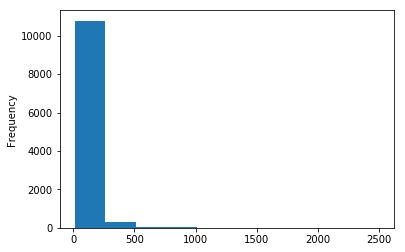

In [40]:
wine["price"].plot(kind='hist')

# We have a lot of "cheap" wine bottles and only a few of prestige. Let's create 8 price buckets.

In [41]:
pd.qcut(wine["price"], q=8)

0        (125.0, 2500.0]
1        (125.0, 2500.0]
2        (125.0, 2500.0]
3           (72.0, 90.0]
4        (125.0, 2500.0]
5        (125.0, 2500.0]
6        (125.0, 2500.0]
7        (125.0, 2500.0]
8           (72.0, 90.0]
9        (125.0, 2500.0]
10       (125.0, 2500.0]
11       (125.0, 2500.0]
12       (125.0, 2500.0]
13       (125.0, 2500.0]
14       (125.0, 2500.0]
15       (125.0, 2500.0]
16       (125.0, 2500.0]
17       (125.0, 2500.0]
18       (125.0, 2500.0]
19          (35.0, 45.0]
20         (90.0, 125.0]
21          (72.0, 90.0]
22       (125.0, 2500.0]
23       (125.0, 2500.0]
24          (72.0, 90.0]
25       (125.0, 2500.0]
26       (125.0, 2500.0]
27       (125.0, 2500.0]
28       (125.0, 2500.0]
29       (125.0, 2500.0]
              ...       
11115    (125.0, 2500.0]
11116     (11.999, 35.0]
11117     (11.999, 35.0]
11118       (50.0, 60.0]
11119     (11.999, 35.0]
11120    (125.0, 2500.0]
11121      (90.0, 125.0]
11122    (125.0, 2500.0]
11123       (50.0, 60.0]


In [ ]:
# Above code suggests us range of each bucket. It would works if we want to have the same number of observations in every bucket (price segment) but we don't so let's modify it a little but base on it

In [42]:
# Some useful statistics
np.std(wine["price"])

95.77959415494183

In [43]:
wine["price"].mean()

83.63059668012562

In [ ]:
"""  
So I decided to use these ranges:
    - Low-Price [0 - 30.0]
    - Value (30.0 - 55.0]
    - Standard (55.0 - 80.0]
    - Premium (80.0 - 120.0]
    - Super Premium (120.0 - 250.0]
    - Ultra Premium (250.0 - 500.0]
    - Prestige (500.0 - 1000.00]
    - Prestige Plus (1000.0 - 2500.0]
"""

In [46]:
# We will work on copy of price column
wine["price segment"] = wine["price"]

In [47]:
# Loop which change price on the right price segment
segment = []

for row in wine["price segment"]:
    if row < 30:
        segment.append('LowPrice')
    elif row < 55:
        segment.append('Value')
    elif row < 80:
        segment.append('Standard')
    elif row < 120:
        segment.append('Premium')
    elif row < 250:
        segment.append('SuperPremium')
    elif row < 500:
        segment.append('UltraPremium')
    elif row < 1000:
        segment.append('Prestige')
    elif row >= 1000:
        segment.append('PrestigePlus')
    else:
        segment.append('Error')
        
wine['price segment'] = segment

In [48]:
wine['price segment'].value_counts()
# No Errors, great!

Value           3817
Standard        3083
Premium         1885
SuperPremium    1237
LowPrice         698
UltraPremium     332
Prestige          79
PrestigePlus      14
Name: price segment, dtype: int64

In [49]:
# We have to rebuild our metadata

def metadata(x):
    return ''.join(x['country']) + ' ' + ''.join(x['points']) + ' ' + x['price segment'] + ' ' + ''.join(x['province'] + ' ' + x['variety'])


In [50]:
wine['metadata'] = wine.apply(metadata, axis=1)

In [51]:
# Once again we have to create the new similarity matrix
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(wine['metadata']) 

In [52]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [53]:
wine = wine.reset_index()
indices = pd.Series(wine.index, index=wine['title'])

In [54]:
wine = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery', 'metadata']]

In [55]:
# New recommendation's def

def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # fit index of the wine to the title
    idx = indices[title]
    
    # similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # show top 10 results with the highest similarity score
    sim_scores = sim_scores[1:11]

    # select indices
    wine_indices = [i[0] for i in sim_scores]

    # return selected wine and the recommendation results in the new dataframe
    recommendation = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery', 'metadata']].iloc[wine_indices]

    frames = [wine[wine["title"] == title], recommendation]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    return recommendation

In [56]:
Recommendation = wine_recommendations('Château Palmer 2009  Margaux')
Recommendation

title country  \
x 82                    Château Palmer 2009  Margaux  France   
y 100  Château Léoville Las Cases 2009  Saint-Julien  France   
  83                   Château Margaux 2009  Margaux  France   
  92    Château Léoville Poyferré 2010  Saint-Julien  France   
  0    Château Léoville Las Cases 2010  Saint-Julien  France   
  237                  Château Margaux 2014  Margaux  France   
  308       Château Lafite Rothschild 2014  Pauillac  France   
  309            Château Angélus 2014  Saint-Émilion  France   
  311        Château Haut-Brion 2014  Pessac-Léognan  France   
  330       Château Mouton Rothschild 2014  Pauillac  France   
  364       Château Cheval Blanc 2014  Saint-Émilion  France   

                                             description points   price  \
x 82   A beautiful wine, with the firmest tannins sur...     98   380.0   
y 100  A beautifully structured wine, with its tannin...     98   360.0   
  83   A massive wine for Margaux, packed with tannin...     98  1900.0   
  92   A wine of architectural strength and classical...     98    92.0   
  0    A hugely powerful wine, full of dark, brooding...    100   359.0   
  237  There is a sense of pure juicy black-currant f...     97   450.0   
  308  This is a major wine. It has enormous tension,...     97   450.0   
  309  Effectively half-and-half Merlot and Cabernet ...     97   285.0   
  311  With seriously dense tannins, this shows great...     97   330.0   
  330  The label of this vintage is designed by David...     96   400.0   
  364  With its high proportion of Cabernet Franc (45...     96   475.0   

      price segment  province                   variety  \
x 82   UltraPremium  Bordeaux  Bordeaux-style Red Blend   
y 100  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  83   PrestigePlus  Bordeaux  Bordeaux-style Red Blend   
  92        Premium  Bordeaux  Bordeaux-style Red Blend   
  0    UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  237  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  308  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  309  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  311  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  330  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  364  UltraPremium  Bordeaux  Bordeaux-style Red Blend   

                           winery  \
x 82               Château Palmer   
y 100  Château Léoville Las Cases   
  83              Château Margaux   
  92    Château Léoville Poyferré   
  0    Château Léoville Las Cases   
  237             Château Margaux   
  308   Château Lafite Rothschild   
  309             Château Angélus   
  311          Château Haut-Brion   
  330   Château Mouton Rothschild   
  364        Château Cheval Blanc   

                                                metadata  
x 82   France 98 UltraPremium Bordeaux Bordeaux-style...  
y 100  France 98 UltraPremium Bordeaux Bordeaux-style...  
  83   France 98 PrestigePlus Bordeaux Bordeaux-style...  
  92   France 98 Premium Bordeaux Bordeaux-style Red ...  
  0    France 100 UltraPremium Bordeaux Bordeaux-styl...  
  237  France 97 UltraPremium Bordeaux Bordeaux-style...  
  308  France 97 UltraPremium Bordeaux Bordeaux-style...  
  309  France 97 UltraPremium Bordeaux Bordeaux-style...  
  311  France 97 UltraPremium Bordeaux Bordeaux-style...  
  330  France 96 UltraPremium Bordeaux Bordeaux-style...  
  364  France 96 UltraPremium Bordeaux Bordeaux-style...

In [ ]:
# Results are already good but we can try to limit metadata to the most important to have more varied recommendations. Let's modify the previous step.

In [57]:
def metadata(x):
    return ''.join(x['points']) + ' ' + x['price segment'] + ' ' + x['variety']

In [58]:
wine['metadata'] = wine.apply(metadata, axis=1)
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(wine['metadata']) 

In [59]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [60]:
wine = wine.reset_index()
indices = pd.Series(wine.index, index=wine['title'])

In [61]:
wine = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery', 'metadata']]

In [62]:
Recommendation = wine_recommendations('Château Palmer 2009  Margaux')
Recommendation

title country  \
x 82                    Château Palmer 2009  Margaux  France   
y 100  Château Léoville Las Cases 2009  Saint-Julien  France   
  83                   Château Margaux 2009  Margaux  France   
  92    Château Léoville Poyferré 2010  Saint-Julien  France   
  0    Château Léoville Las Cases 2010  Saint-Julien  France   
  237                  Château Margaux 2014  Margaux  France   
  308       Château Lafite Rothschild 2014  Pauillac  France   
  309            Château Angélus 2014  Saint-Émilion  France   
  311        Château Haut-Brion 2014  Pessac-Léognan  France   
  330       Château Mouton Rothschild 2014  Pauillac  France   
  364       Château Cheval Blanc 2014  Saint-Émilion  France   

                                             description points   price  \
x 82   A beautiful wine, with the firmest tannins sur...     98   380.0   
y 100  A beautifully structured wine, with its tannin...     98   360.0   
  83   A massive wine for Margaux, packed with tannin...     98  1900.0   
  92   A wine of architectural strength and classical...     98    92.0   
  0    A hugely powerful wine, full of dark, brooding...    100   359.0   
  237  There is a sense of pure juicy black-currant f...     97   450.0   
  308  This is a major wine. It has enormous tension,...     97   450.0   
  309  Effectively half-and-half Merlot and Cabernet ...     97   285.0   
  311  With seriously dense tannins, this shows great...     97   330.0   
  330  The label of this vintage is designed by David...     96   400.0   
  364  With its high proportion of Cabernet Franc (45...     96   475.0   

      price segment  province                   variety  \
x 82   UltraPremium  Bordeaux  Bordeaux-style Red Blend   
y 100  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  83   PrestigePlus  Bordeaux  Bordeaux-style Red Blend   
  92        Premium  Bordeaux  Bordeaux-style Red Blend   
  0    UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  237  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  308  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  309  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  311  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  330  UltraPremium  Bordeaux  Bordeaux-style Red Blend   
  364  UltraPremium  Bordeaux  Bordeaux-style Red Blend   

                           winery                                   metadata  
x 82               Château Palmer   98 UltraPremium Bordeaux-style Red Blend  
y 100  Château Léoville Las Cases   98 UltraPremium Bordeaux-style Red Blend  
  83              Château Margaux   98 PrestigePlus Bordeaux-style Red Blend  
  92    Château Léoville Poyferré        98 Premium Bordeaux-style Red Blend  
  0    Château Léoville Las Cases  100 UltraPremium Bordeaux-style Red Blend  
  237             Château Margaux   97 UltraPremium Bordeaux-style Red Blend  
  308   Château Lafite Rothschild   97 UltraPremium Bordeaux-style Red Blend  
  309             Château Angélus   97 UltraPremium Bordeaux-style Red Blend  
  311          Château Haut-Brion   97 UltraPremium Bordeaux-style Red Blend  
  330   Château Mouton Rothschild   96 UltraPremium Bordeaux-style Red Blend  
  364        Château Cheval Blanc   96 UltraPremium Bordeaux-style Red Blend

In [ ]:

"""
Now I am happy with the recommendations which we created. As you see, Château Palmer 2009 Margaux is a really good wine (98 points) but the bottle is expensive (380.00 USD). Thanks to our engine, we found a cheaper alternative.
Château Léoville Poyferré 2010  Saint-Julien has the same number of points but the price is only 92.00 USD and both wines are from Bordeaux, France!
I hope you had fun and learnt a lot. Thank you!

Kamil Jankowski
Stay in touch: https://www.linkedin.com/in/kamil-jankowski-bb8b38165

""'